# 1. Build an image segmentation model using pytorch

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.amp import autocast, GradScaler

# Dataset path
dataset_path = '/Users/tanaygawade/Downloads/Neural/Bird_sound_Project'

# Custom Dataset

class CustomBirdDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'images')
        self.mask_dir = os.path.join(data_dir, 'masks')
        self.image_files = sorted([file for file in os.listdir(self.image_dir) if file.endswith(('png', 'jpg', 'jpeg'))])
        self.mask_files = sorted([file for file in os.listdir(self.mask_dir) if file.endswith(('png', 'jpg', 'jpeg'))])
        self.transform = transform

        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks count!"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_files[index])
        mask_path = os.path.join(self.mask_dir, self.mask_files[index])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [28]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images and masks to 256x256
    transforms.ToTensor(),
])

# Load data
train_dataset = BirdDataset(os.path.join(dataset_path, 'train'), transform=transform)
test_dataset = BirdDataset(os.path.join(dataset_path, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

# Pre-trained Encoder-based Model
class UNetWithGoogleNetEncoder(nn.Module):
    def __init__(self):
        super(UNetWithGoogleNetEncoder, self).__init__()

        # Load the pretrained GoogLeNet model
        googlenet = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        self.enc1 = nn.Sequential(googlenet.conv1, googlenet.maxpool1)  # Initial conv layer
        self.enc2 = googlenet.inception3a  # First inception block
        self.enc3 = googlenet.inception3b  # Second inception block
        self.enc4 = googlenet.inception4a  # Third inception block

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(128, 64)

        # Final output
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decoder
        dec1 = self.up1(bottleneck)
        if dec1.size()[2:] != enc4.size()[2:]:
            enc4 = torch.nn.functional.interpolate(enc4, size=dec1.size()[2:], mode='bilinear', align_corners=False)
        dec1 = self.dec1(torch.cat([dec1, enc4], dim=1))

        dec2 = self.up2(dec1)
        if dec2.size()[2:] != enc3.size()[2:]:
            enc3 = torch.nn.functional.interpolate(enc3, size=dec2.size()[2:], mode='bilinear', align_corners=False)
        dec2 = self.dec2(torch.cat([dec2, enc3], dim=1))

        dec3 = self.up3(dec2)
        if dec3.size()[2:] != enc2.size()[2:]:
            enc2 = torch.nn.functional.interpolate(enc2, size=dec3.size()[2:], mode='bilinear', align_corners=False)
        dec3 = self.dec3(torch.cat([dec3, enc2], dim=1))

        dec4 = self.up4(dec3)
        if dec4.size()[2:] != enc1.size()[2:]:
            enc1 = torch.nn.functional.interpolate(enc1, size=dec4.size()[2:], mode='bilinear', align_corners=False)
        dec4 = self.dec4(torch.cat([dec4, enc1], dim=1))

        # Final output
        out = self.final(dec4)
        return out

# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

In [35]:
# Training setup
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = UNetWithGoogleNetEncoder().to(device)

# Loss function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        smooth = 1.0
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice

criterion = lambda pred, target: nn.BCEWithLogitsLoss()(pred, target) + DiceLoss()(pred, target)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Reduced initial learning rate
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=50)
scaler = GradScaler(init_scale=2.**16, growth_factor=2., backoff_factor=0.5, growth_interval=200, enabled=True)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        masks = masks.unsqueeze(1) if masks.dim() == 3 else masks

        with autocast("mps"):
            outputs = model(images)
            outputs = torch.nn.functional.interpolate(outputs, size=masks.size()[2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        optimizer.zero_grad()
        epoch_loss += loss.item()

    scheduler.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [1/200], Loss: 1.2519
Epoch [2/200], Loss: 1.0602
Epoch [3/200], Loss: 0.9935
Epoch [4/200], Loss: 0.9530
Epoch [5/200], Loss: 0.9150
Epoch [6/200], Loss: 0.8820
Epoch [7/200], Loss: 0.8592
Epoch [8/200], Loss: 0.8302
Epoch [9/200], Loss: 0.8022
Epoch [10/200], Loss: 0.7815
Epoch [11/200], Loss: 0.7580
Epoch [12/200], Loss: 0.7290
Epoch [13/200], Loss: 0.7115
Epoch [14/200], Loss: 0.6946
Epoch [15/200], Loss: 0.6670
Epoch [16/200], Loss: 0.6556
Epoch [17/200], Loss: 0.6315
Epoch [18/200], Loss: 0.6095
Epoch [19/200], Loss: 0.5871
Epoch [20/200], Loss: 0.5656
Epoch [21/200], Loss: 0.5494
Epoch [22/200], Loss: 0.5345
Epoch [23/200], Loss: 0.5123
Epoch [24/200], Loss: 0.4991
Epoch [25/200], Loss: 0.4729
Epoch [26/200], Loss: 0.4533
Epoch [27/200], Loss: 0.4409
Epoch [28/200], Loss: 0.4284
Epoch [29/200], Loss: 0.4105
Epoch [30/200], Loss: 0.3989
Epoch [31/200], Loss: 0.3891
Epoch [32/200], Loss: 0.3740
Epoch [33/200], Loss: 0.3613
Epoch [34/200], Loss: 0.3511
Epoch [35/200], Loss: 0

# 3.Evaluate your model using the test images

Mean IoU: 0.6391


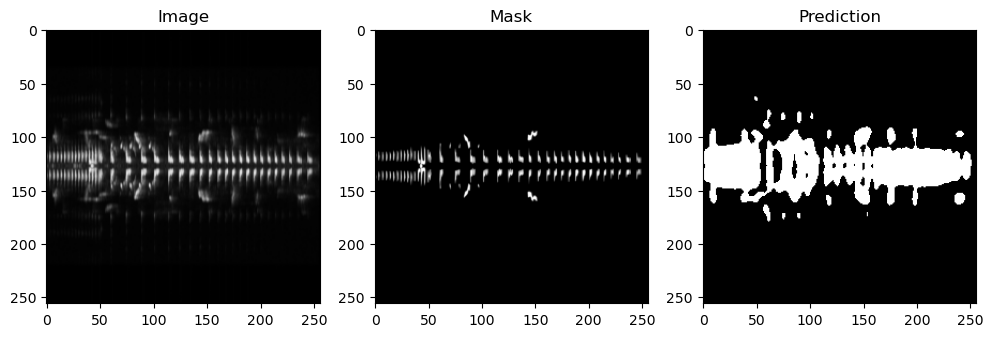

In [37]:

# Evaluation
model.eval()
iou_scores = []
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        masks = masks.unsqueeze(1) if masks.dim() == 3 else masks
        outputs = model(images)
        outputs = torch.sigmoid(torch.nn.functional.interpolate(outputs, size=masks.size()[2:], mode='bilinear', align_corners=False))
        outputs = (outputs > 0.5).float()
        intersection = (outputs * masks).sum()
        union = (outputs + masks).sum()
        iou_scores.append((intersection / (union - intersection + 1e-6)).item())

print(f"Mean IoU: {np.mean(iou_scores):.4f}")

# Visualize
def visualize_sample(image, mask, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title("Image")
    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title("Mask")
    axes[2].imshow(prediction.squeeze(), cmap='gray')
    axes[2].set_title("Prediction")
    plt.show()

# Visualize one test sample
sample_image, sample_mask = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)
sample_output = model(sample_image)
sample_output = torch.sigmoid(torch.nn.functional.interpolate(sample_output, size=sample_mask.size()[1:], mode='bilinear', align_corners=False))
sample_output = (sample_output > 0.5).float()
visualize_sample(sample_image.cpu().squeeze(), sample_mask, sample_output.cpu().squeeze())


## visualization

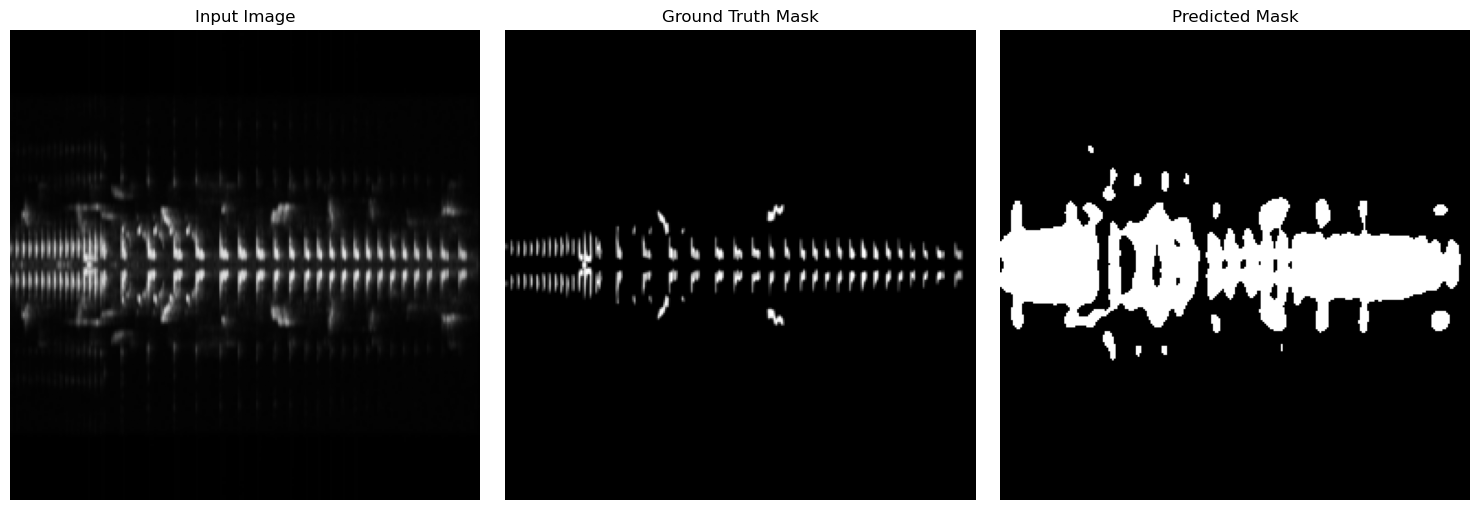

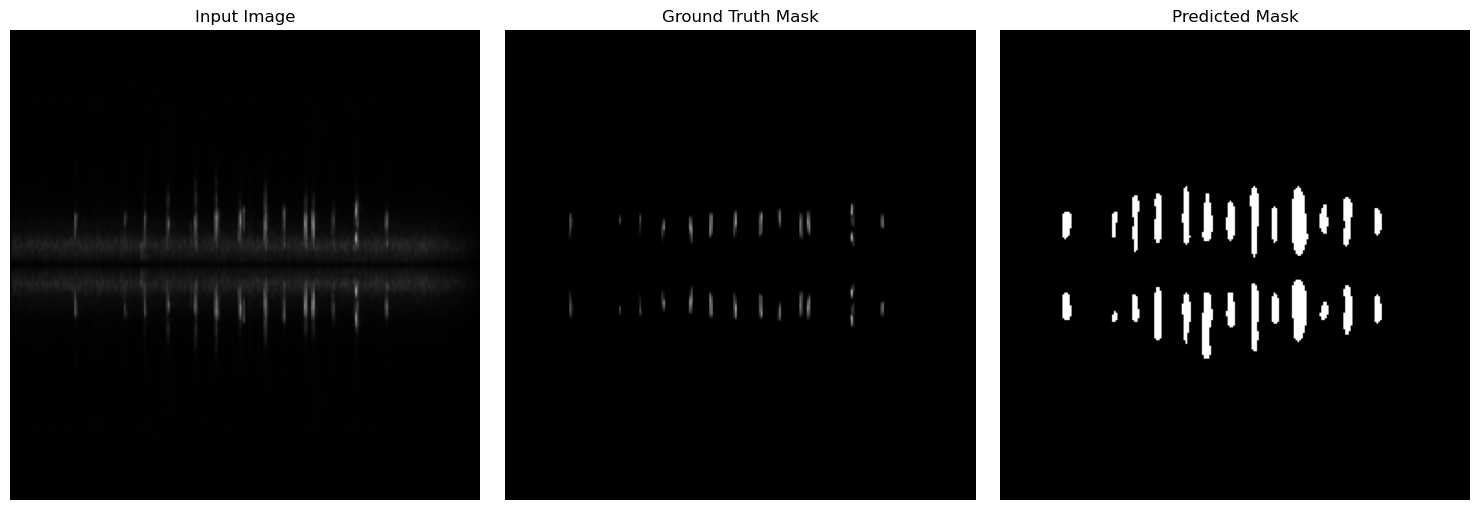

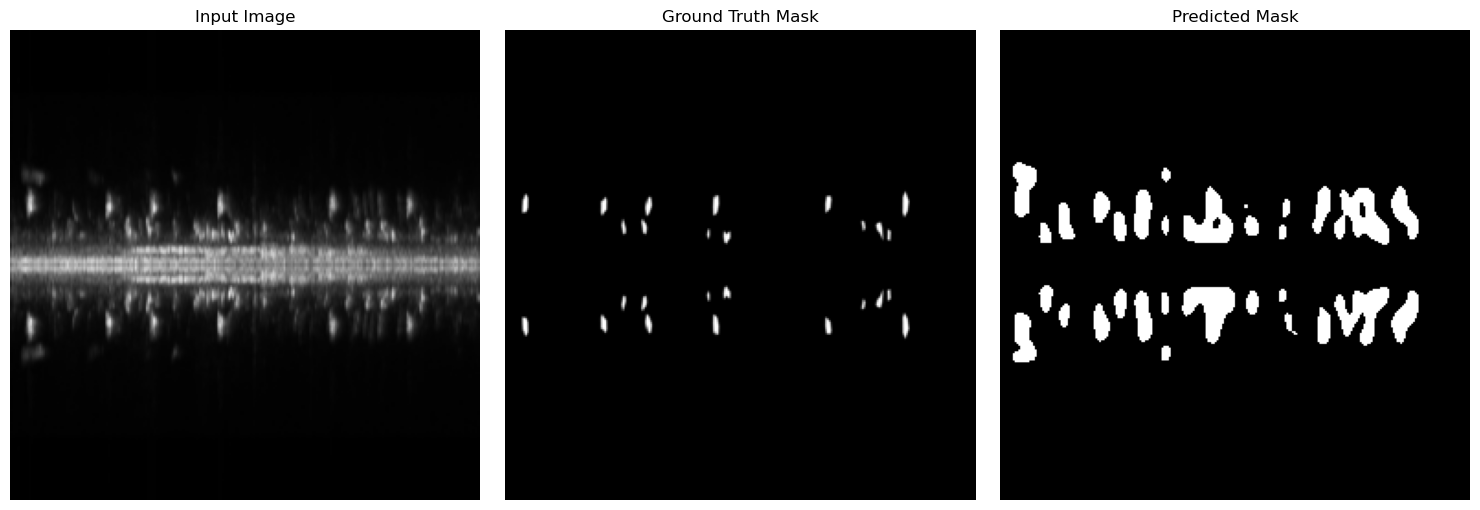

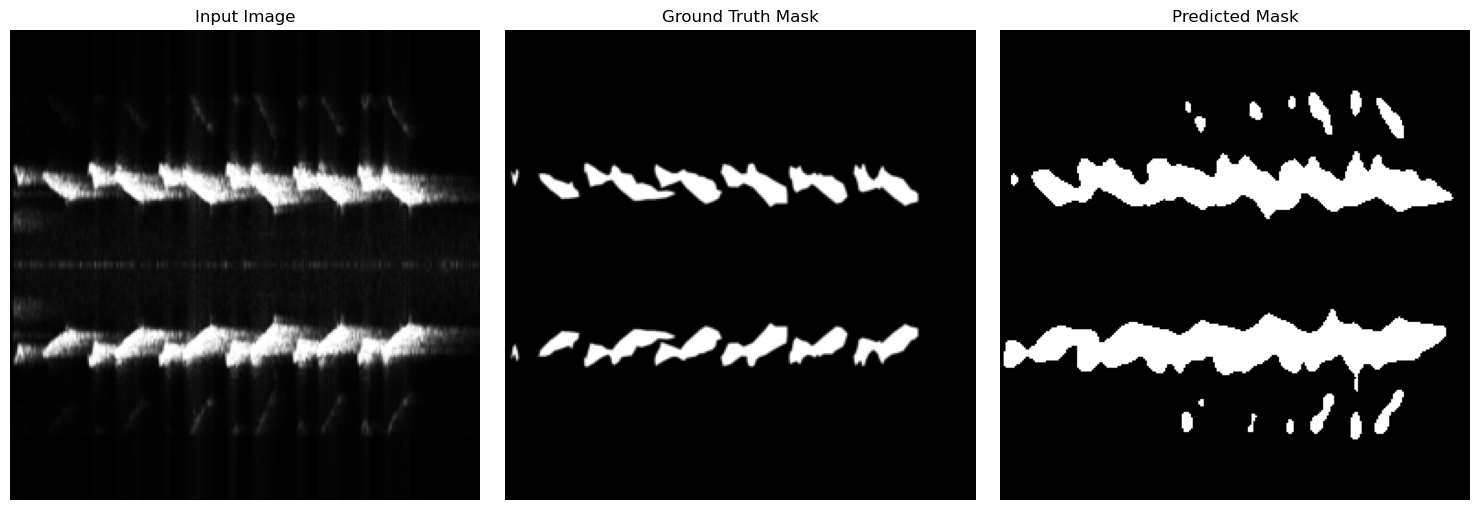

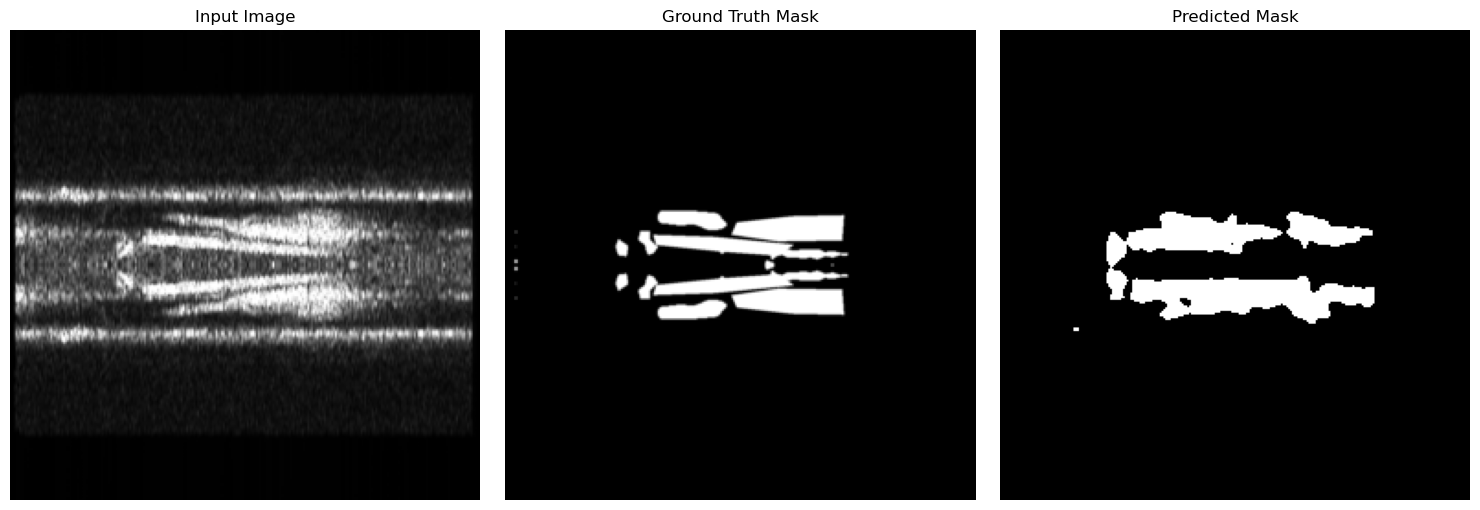

In [47]:
import matplotlib.pyplot as plt
import torch

def visualize_multiple_samples(test_dataset, model, device, num_samples=5, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    model.eval()  # Set the model to evaluation mode

    for i in range(num_samples):
        sample_image, sample_mask = test_dataset[i]
        sample_image = sample_image.unsqueeze(0).to(device)

        with torch.no_grad():
            sample_output = model(sample_image)
            sample_output = torch.sigmoid(torch.nn.functional.interpolate(
                sample_output, size=sample_mask.size()[1:], mode='bilinear', align_corners=False
            ))
            sample_output = (sample_output > 0.5).float()

        # Denormalize the input image
        denorm_image = denormalize(sample_image.cpu().squeeze(), mean, std)

        # Plot the results
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Input Image
        axes[0].imshow(sample_image.cpu().squeeze().permute(1, 2, 0))
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        # Ground Truth Mask
        axes[1].imshow(sample_mask.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis("off")

        # Predicted Mask
        axes[2].imshow(sample_output.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

# Denormalize utility
def denormalize(image, mean, std):
    image = image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return image.clamp(0, 1)

# Visualize predictions
visualize_multiple_samples(test_dataset, model, device, num_samples=5)


## Plot between IOU, Dice and Epoch

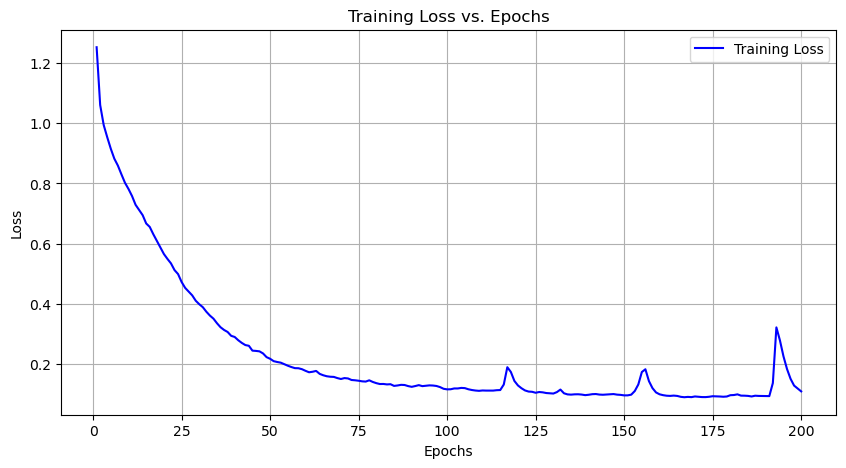

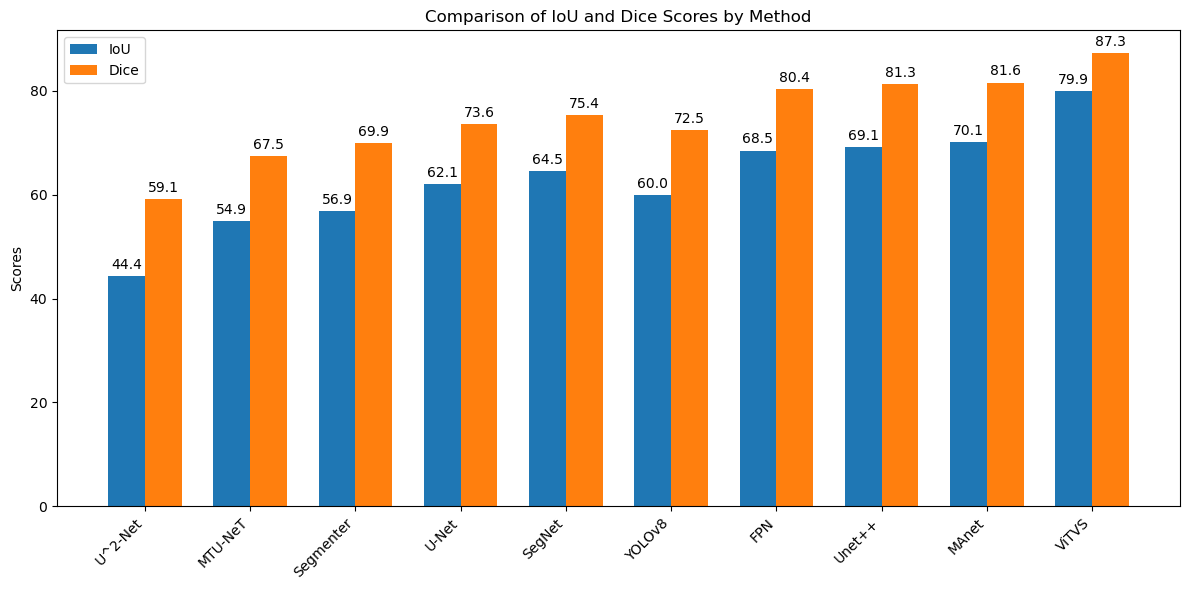

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the provided training logs and table for comparison
epochs = list(range(1, 201))
loss_values = [
    1.2519, 1.0602, 0.9935, 0.9530, 0.9150, 0.8820, 0.8592, 0.8302, 0.8022, 0.7815,
    0.7580, 0.7290, 0.7115, 0.6946, 0.6670, 0.6556, 0.6315, 0.6095, 0.5871, 0.5656,
    0.5494, 0.5345, 0.5123, 0.4991, 0.4729, 0.4533, 0.4409, 0.4284, 0.4105, 0.3989,
    0.3891, 0.3740, 0.3613, 0.3511, 0.3358, 0.3226, 0.3136, 0.3069, 0.2942, 0.2903,
    0.2795, 0.2707, 0.2635, 0.2611, 0.2450, 0.2441, 0.2426, 0.2357, 0.2234, 0.2180,
    0.2101, 0.2073, 0.2051, 0.2001, 0.1950, 0.1906, 0.1869, 0.1866, 0.1834, 0.1780, 
    0.1732, 0.1749, 0.1777, 0.1679, 0.1633, 0.1600, 0.1584, 0.1578, 0.1539, 0.1509, 
    0.1539, 0.1527, 0.1476, 0.1466, 0.1451, 0.1431, 0.1423, 0.1465, 0.1411, 0.1371, 
    0.1342, 0.1344, 0.1329, 0.1336, 0.1280, 0.1294, 0.1315, 0.1309, 0.1273, 0.1249, 
    0.1275, 0.1305, 0.1272, 0.1284, 0.1297, 0.1292, 0.1277, 0.1240, 0.1184, 0.1165, 
    0.1168, 0.1195, 0.1195, 0.1213, 0.1206, 0.1168, 0.1143, 0.1126, 0.1116, 0.1128, 
    0.1124, 0.1125, 0.1124, 0.1137, 0.1142, 0.1325, 0.1900, 0.1742, 0.1444, 0.1295, 
    0.1202, 0.1129, 0.1092, 0.1084, 0.1052, 0.1077, 0.1066, 0.1043, 0.1036, 0.1026, 
    0.1074, 0.1158, 0.1035, 0.0998, 0.0990, 0.1000, 0.1002, 0.0992, 0.0973, 0.0986, 
    0.1005, 0.1010, 0.0992, 0.0986, 0.0994, 0.1002, 0.1009, 0.0990, 0.0982, 0.0965, 
    0.0966, 0.0989, 0.1109, 0.1327, 0.1740, 0.1832, 0.1439, 0.1206, 0.1063, 0.1001, 
    0.0972, 0.0954, 0.0948, 0.0958, 0.0947, 0.0917, 0.0904, 0.0915, 0.0907, 0.0929, 
    0.0919, 0.0909, 0.0908, 0.0919, 0.0937, 0.0934, 0.0928, 0.0920, 0.0928, 0.0971, 
    0.0977, 0.0999, 0.0957, 0.0955, 0.0948, 0.0929, 0.0954, 0.0947, 0.0945, 0.0943, 
    0.0941, 0.1375, 0.3221, 0.2790, 0.2261, 0.1840, 0.1515, 0.1290, 0.1196, 0.1098
]

# Your model's IoU, Dice, and F1 on the test set
your_model_metrics = [63.91, 79.9, 87.3]  

# Table values (test metrics for various models)
table_metrics = {
    "U^2-Net": [44.4, 59.1],
    "MTU-NeT": [54.9, 67.5],
    "Segmenter": [56.9, 69.9],
    "U-Net": [62.1, 73.6],
    "SegNet": [64.5, 75.4],
    "YOLOv8": [60.0, 72.5],
    "FPN": [68.5, 80.4],
    "Unet++": [69.1, 81.3],
    "MAnet": [70.1, 81.6],
    "ViTVS": [79.9, 87.3],  # Best values from the table
}

# Extract methods, IoU, and Dice values
methods = list(table_metrics.keys())
iou_values = [metrics[0] for metrics in table_metrics.values()]
dice_values = [metrics[1] for metrics in table_metrics.values()]

# Plot Training Loss vs. Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot IoU, Dice, and F1 comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(methods))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width / 2, iou_values, width, label='IoU')
rects2 = ax.bar(x + width / 2, dice_values, width, label='Dice')

# Add labels, title, and legend
ax.set_ylabel('Scores')
ax.set_title('Comparison of IoU and Dice Scores by Method')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend()

# Add bar labels
ax.bar_label(rects1, padding=3, fmt='%.1f')
ax.bar_label(rects2, padding=3, fmt='%.1f')

fig.tight_layout()
plt.show()


LINK to ResearchGate: https://www.researchgate.net/publication/387186976_Bird_Sound_Denoising_Using_Residual_Blocks_in_a_U-Net_Architecture